In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import os
os.chdir('/home/piotr/Zasoby/Python/Work')

In [2]:
kgh = pd.read_csv('kgh.csv')
kgh.tail(2)

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
249,2021-06-16,183.45,185.93,181.02,183.95,879120
250,2021-06-17,181.47,182.41,175.32,177.45,1159568


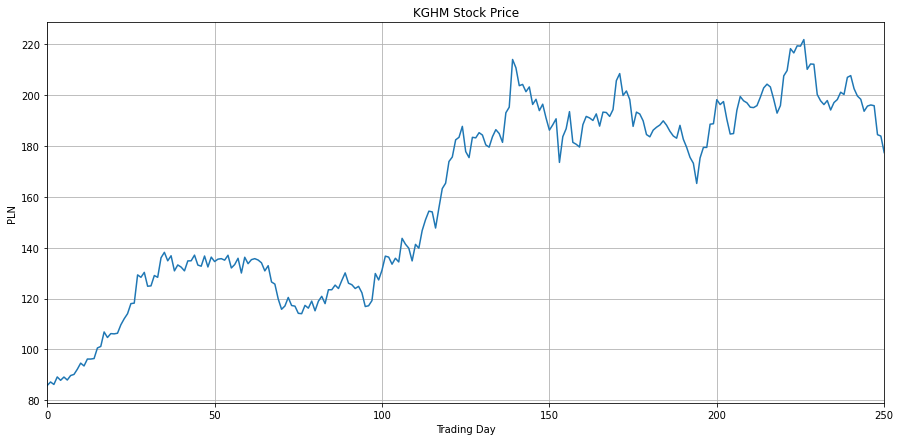

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.title('KGHM Stock Price')
plt.ylabel('PLN')
plt.xlabel('Trading Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(kgh.iloc[:, -2].values)
plt.show()

In [4]:
kgh.columns

Index(['Data', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen'], dtype='object')

In [5]:
all_data = kgh['Zamkniecie'].values

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
all_data_normalized = scaler.fit_transform(all_data.reshape(-1, 1))

In [7]:
all_data_normalized = torch.FloatTensor(all_data_normalized).view(-1)

In [8]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [9]:
train_window = 10
test_data_size = 10
train_inout_seq = create_inout_sequences(all_data_normalized[:], train_window)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        #self.lstm2 = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [13]:
model = LSTM(1,50,1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [14]:
epochs = 20

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.6f}')

print(f'epoch: {(i+1):3} loss: {single_loss.item():10.6f}')

epoch:   1 loss:   0.010066
epoch:   3 loss:   0.010218
epoch:   5 loss:   0.008195
epoch:   7 loss:   0.006577
epoch:   9 loss:   0.006545
epoch:  11 loss:   0.006652
epoch:  13 loss:   0.006648
epoch:  15 loss:   0.006627
epoch:  17 loss:   0.006622
epoch:  19 loss:   0.006598
epoch:  20 loss:   0.006598


Predykcja odtwarzająca dane historyczne

In [15]:
test_inputs = all_data_normalized[:].tolist()
test_outputs = list()
for i in range(len(test_inputs)-train_window):
    seq = torch.FloatTensor(test_inputs[i:i+train_window])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_outputs.append(model(seq).item())

In [16]:
actual_predictions = scaler.inverse_transform(np.array(test_outputs ).reshape(-1, 1))
x = np.arange(train_window, len(all_data), 1)
print(len(x), len(actual_predictions))

241 241


In [17]:
RMSE = np.sqrt(sum((np.array([e.item() for e in actual_predictions])-all_data[train_window:])**2)/ 
               len(actual_predictions))
print('RMSE = {:.3f}'.format(RMSE))

RMSE = 12.450


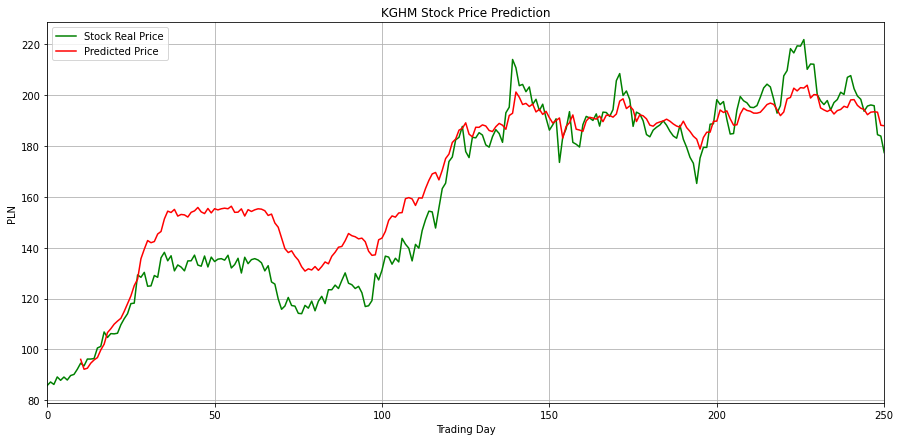

In [18]:
plt.rcParams["figure.figsize"] = fig_size
plt.plot(all_data, color = 'g', label = 'Stock Real Price')
plt.plot(x, actual_predictions, color = 'r', label = 'Predicted Price')
plt.title('KGHM Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('PLN')
plt.autoscale(axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()

Predykcja przyszłych notowań

In [48]:
fut_pred = 10
test_inputs = all_data_normalized[:-test_data_size].tolist()

In [49]:
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [50]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[-fut_pred:] ).reshape(-1, 1))
RMSE = np.sqrt(sum((np.array([e.item() for e in actual_predictions])-all_data[-fut_pred:])**2)/fut_pred)
print('RMSE = {:.3f}'.format(RMSE))

RMSE = 6.668


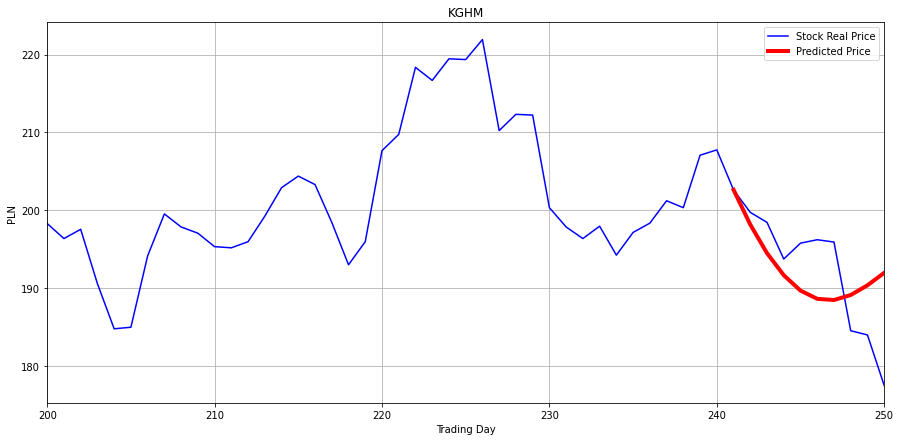

In [51]:
plt.rcParams["figure.figsize"] = fig_size
plt.plot(np.arange(200, len(all_data),1), all_data[200:], color = 'b', label = 'Stock Real Price')
plt.plot(np.arange(len(all_data)-fut_pred, len(all_data),1), actual_predictions, 
         color = 'r', lw = 4, label = 'Predicted Price')
plt.title('KGHM')
plt.ylabel('PLN')
plt.xlabel('Trading Day')
plt.autoscale(axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()